<a href="https://colab.research.google.com/github/vincm1/UK_accidents/blob/main/Final_assignment_Big_Data_for_Decision_Making_(2021_22_BNK432_NO02_A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Final assignment - Big Data for Decision Making (2021-22 BNK432_NO02_A)

In [186]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [219]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [188]:
df = pd.read_csv("UK Road Accidents 2018.csv")
df.head()

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area
0,2018-01-01 00:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban
1,2018-01-01 01:00:00,9,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
2,2018-01-01 02:00:00,14,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
3,2018-01-01 03:00:00,10,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban
4,2018-01-01 04:00:00,8,Monday,Fine,False,Dry,Darkness - lights lit,Urban


## 1) **Business** **objective**

The above seen data set is published by the UK Department for Transport and is published sinced 1978. For this report, a snippet of the data is taken and handles all road accidents that happened in 2018 on an hourly level. The data contains information about the hour as well as the count of how many accidents happened on UK's streets. Furthermore, it shows which day of the week it has been, the condition of precipitation within that time as well as whether there was high wind. Moreover, the dataset contains information about the road surface conditions, light conditions and in what kind of area the accidents in that hour happened.

The goal of this report is to forecast the number of hourly accidents occuring on UK streets for Britannia Rescue in order to help its rescourcing planning by an appropriate model.

To predict the numbers the following report structure will be included. First, the data will explored and preprocessed. Secondly, the features are selected and a baseline model will be drawn. Thirdly, models will be trained, hyperparameters tuned and thereby evaluated, which model shows the best performance for predicting road accidents for the client. To sum up, the results will be discussed and further steps will be introduced.

### Data inspection 

In [190]:
df.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area'],
      dtype='object')

Creating more granularity in the date info

In [191]:
df["datetime"] = pd.to_datetime(df["datetime"])

In [193]:
df["day"] = df["datetime"].dt.date
df["day"] = pd.to_datetime(df["day"])

In [346]:
df["day_n"] = df["datetime"].dt.day

In [194]:
df["hour"] = df["datetime"].dt.hour

In [195]:
df["month"] = df["datetime"].dt.month_name()

In [345]:
df["month_n"] = df["datetime"].dt.month

In [196]:
df.loc[(df['Day_of_Week'] == 'Saturday') | (df['Day_of_Week'] == 'Sunday'), 'Weekend'] = 'Weekend'
df.loc[(df['Day_of_Week'] != 'Saturday') & (df['Day_of_Week'] != 'Sunday'), 'Weekend'] = 'Weekday'  

In [381]:
conditions_season = [
                     ((df["month"] == "December") | (df["month"] == "January") | (df["month"] == "February")),
                     ((df["month"] == "March") | (df["month"] == "April") | (df["month"] == "May")),
                     ((df["month"] == "June") | (df["month"] == "July") | (df["month"] == "August")),
                     (df["month"] == "September") | (df["month"] == "October") | (df["month"] == "November")
]

values_season = ["Winter","Spring","Summer","Autumn"]

df["Season"] = np.select(conditions_season, values_season)

In [389]:
df[6000:]

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day,hour,month,Weekend,month_n,day_n,Season
6000,2018-09-15 01:00:00,8,Saturday,Fine,False,Dry,Darkness - lights lit,Urban,2018-09-15,1,September,Weekend,9,15,Autumn
6001,2018-09-15 02:00:00,4,Saturday,Fine,False,Dry,Darkness - lights lit,Urban,2018-09-15,2,September,Weekend,9,15,Autumn
6002,2018-09-15 03:00:00,3,Saturday,Fine,False,Dry,Darkness - lights lit,Urban,2018-09-15,3,September,Weekend,9,15,Autumn
6003,2018-09-15 04:00:00,5,Saturday,Fine,False,Dry,Darkness - lights lit,Urban,2018-09-15,4,September,Weekend,9,15,Autumn
6004,2018-09-15 05:00:00,4,Saturday,Fine,False,Dry,Darkness - lighting unknown,Rural,2018-09-15,5,September,Weekend,9,15,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8535,2018-12-31 19:00:00,13,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-12-31,19,December,Weekday,12,31,Winter
8536,2018-12-31 20:00:00,12,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-12-31,20,December,Weekday,12,31,Winter
8537,2018-12-31 21:00:00,5,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-12-31,21,December,Weekday,12,31,Winter
8538,2018-12-31 22:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-12-31,22,December,Weekday,12,31,Winter


In [198]:
cat_names = ['Day_of_Week', 'Weekend','Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']
print("Unique count of categorical features:")
for i in cat_names:
  print(i,df[i].unique().size)

Unique count of categorical features:
Day_of_Week 7
Weekend 2
Precipitation 7
High_Winds 2
Road_Surface_Conditions 6
Light_Conditions 5
Urban_or_Rural_Area 2


In [199]:
for i in cat_names:
  print(i,df[i].unique())

Day_of_Week ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']
Weekend ['Weekday' 'Weekend']
Precipitation ['Fine' 'Other' 'Raining' 'Fog or mist' 'Unknown' 'Snowing'
 'Data missing or out of range']
High_Winds [False  True]
Road_Surface_Conditions ['Dry' 'Wet or damp' 'Frost or ice' 'Snow' 'Flood over 3cm. deep'
 'Data missing or out of range']
Light_Conditions ['Darkness - lights lit' 'Daylight' 'Darkness - no lighting'
 'Darkness - lighting unknown' 'Darkness - lights unlit']
Urban_or_Rural_Area ['Urban' 'Rural']


In [324]:
print(f"From ",df["day"].min(), "to ", df["day"].max(),": " ,df.Count.sum()," accidents occured.")

From  2018-01-01 00:00:00 to  2018-12-31 00:00:00 :  122622  accidents occured.


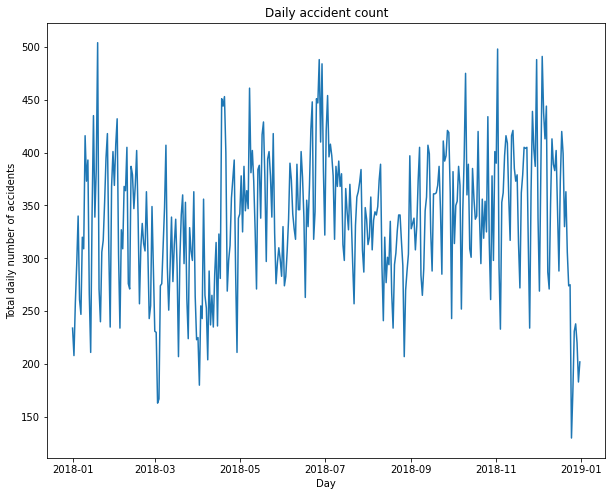

In [325]:
acc_daily = df.groupby("day").sum("Count")
acc_daily.drop(columns=["High_Winds","hour"],inplace=True)

plt.figure(figsize=(10,8))
plt.title("Daily accident count")
plt.plot(acc_daily)
plt.xlabel("Day")
plt.ylabel("Total daily number of accidents")
plt.show()

### **2) Train / Test Split**

In [201]:
train_set, test_set = train_test_split(df,test_size=0.2, random_state=7, shuffle=False)
print(f"{train_set.shape[0]} tain and {test_set.shape[0]} test instances")

6832 tain and 1708 test instances


In [202]:
train_set.head()

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day,hour,month,Weekend
0,2018-01-01 00:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-01-01,0,January,Weekday
1,2018-01-01 01:00:00,9,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban,2018-01-01,1,January,Weekday
2,2018-01-01 02:00:00,14,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban,2018-01-01,2,January,Weekday
3,2018-01-01 03:00:00,10,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban,2018-01-01,3,January,Weekday
4,2018-01-01 04:00:00,8,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-01-01,4,January,Weekday


### **3) EDA & Descriptive Statistics**

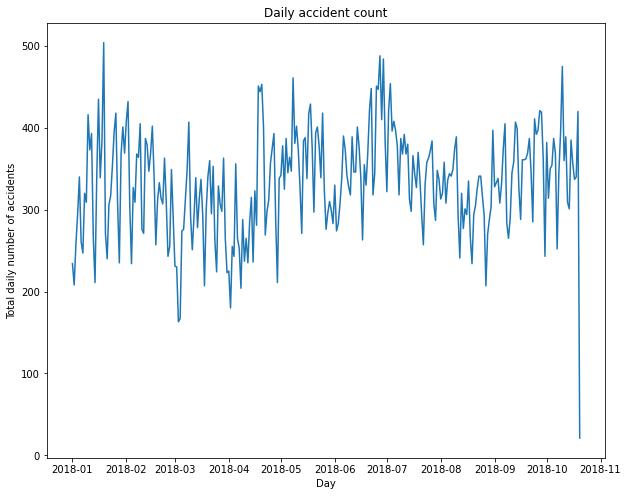

In [335]:
acc_daily_train = train_set.groupby("day").sum("Count")
acc_daily_train.drop(columns=["High_Winds","hour"],inplace=True)

plt.figure(figsize=(10,8))
plt.title("Daily accident count")
plt.plot(acc_daily_train)
plt.xlabel("Day")
plt.ylabel("Total daily number of accidents")
plt.show()

In [334]:
print(f"As the graph shows the daily accident numbers swing between:", acc_daily_train["Count"].max(),"as maximum and",acc_daily_train["Count"].min(),"minimun." )

As the graph shows the daily accident numbers swing between: 504 as maximum and 21 minimun.


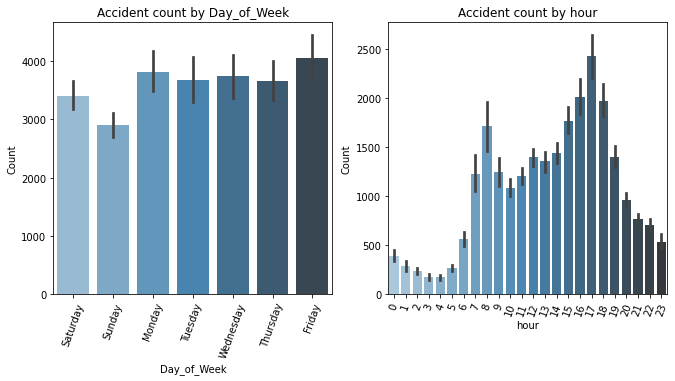

In [207]:
c = 1

fig = plt.figure(figsize=(17,5))

for i in df[["Day_of_Week","hour"]]:
    plt.subplot(1, 3, c)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=test_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

Concerning the date and time of the data one can recognize that accidents are evenly distributed between the weekdays and only *sligthly* peak on Fridays and have a *slight* bottom on Sundays. 
Regarding the hours there is a more clear distribution towards the rush hour hours from 16:00 to 18:00 as well as in the mornings between 7:00 and 9:00. 

In [208]:
test_set.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'day', 'hour', 'month', 'Weekend'],
      dtype='object')

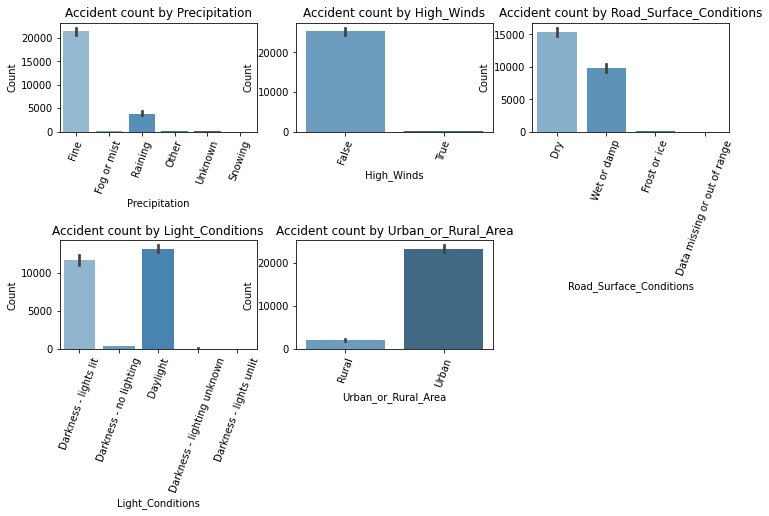

In [209]:
c = 1

fig = plt.figure(figsize=(12,6))

for i in df[['Precipitation',
       'High_Winds', 'Road_Surface_Conditions', 'Light_Conditions',
       'Urban_or_Rural_Area']]:
    plt.subplot(2, 3, c)
    plt.subplots_adjust(hspace=1)
    plt.title(f'Accident count by {i}')
    plt.xlabel(i)
    plt.xticks(rotation=70)
    sns.barplot(x=i,y="Count",data=test_set,estimator=sum, palette="Blues_d")
    c = c + 1

plt.show()

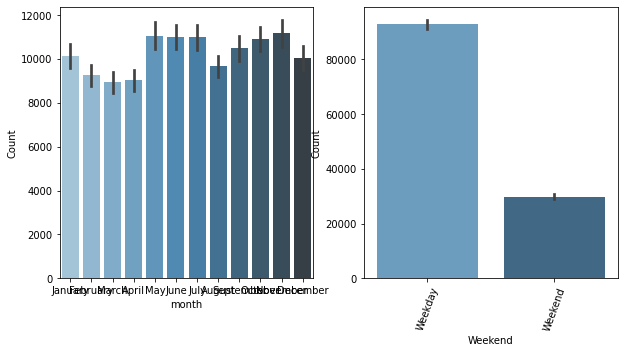

In [218]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
sns.barplot(ax= axes[0], data=df, x='month', y='Count',estimator=sum,palette="Blues_d")
sns.barplot(ax=axes[1], data=df, x='Weekend', y='Count',estimator=sum,palette="Blues_d")
plt.show()

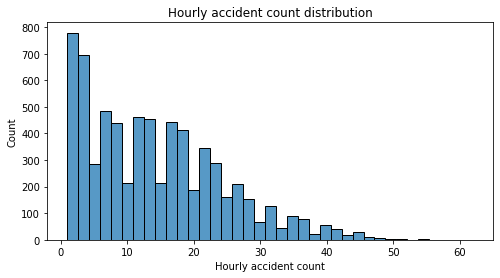

In [344]:
plt.figure(figsize=(8,4))
sns.histplot(data=train_set, x="Count")
plt.title("Hourly accident count distribution")
plt.xlabel("Hourly accident count")
plt.show()

### 3) **Data Preprocessing**

In [212]:
train_set.isna().sum()

datetime                   0
Count                      0
Day_of_Week                0
Precipitation              0
High_Winds                 0
Road_Surface_Conditions    0
Light_Conditions           0
Urban_or_Rural_Area        0
day                        0
hour                       0
month                      0
Weekend                    0
dtype: int64

In [361]:

for i in train_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = train_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Saturday     981
Friday       977
Monday       975
Sunday       974
Wednesday    967
Thursday     967
Tuesday      953
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine           6094
Raining         528
Snowing         116
Other            41
Fog or mist      15
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    6737
True       57
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry                             5329
Wet or damp                     1300
Snow                             115
Frost or ice                      48
Data missing or out of range       2
Name: Road_Surface_Conditions, dtype: int64
Column name is:  Light_Conditions and its unique value counts are: Daylight                       4107
Darkness - lights lit          2203
Darkness - no lighting     

In [362]:
train_set.loc[train_set["Road_Surface_Conditions"].str.contains("Flood"), "Road_Surface_Conditions"] = "Wet or damp"

In [366]:
indexNames = train_set[(train_set['Precipitation'] == "Unknown") | (train_set['Precipitation'] == "Data missing or out of range") | (train_set["Road_Surface_Conditions"] == "Data missing or out of range")].index
train_set.drop(indexNames , inplace=True)


In [367]:
for i in train_set[['Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area']]:
    x = train_set[i].value_counts()
    print("Column name is: ",i,"and its unique value counts are:",x)

Column name is:  Day_of_Week and its unique value counts are: Saturday     981
Friday       977
Monday       975
Sunday       973
Wednesday    967
Thursday     967
Tuesday      952
Name: Day_of_Week, dtype: int64
Column name is:  Precipitation and its unique value counts are: Fine           6092
Raining         528
Snowing         116
Other            41
Fog or mist      15
Name: Precipitation, dtype: int64
Column name is:  High_Winds and its unique value counts are: False    6735
True       57
Name: High_Winds, dtype: int64
Column name is:  Road_Surface_Conditions and its unique value counts are: Dry             5329
Wet or damp     1300
Snow             115
Frost or ice      48
Name: Road_Surface_Conditions, dtype: int64
Column name is:  Light_Conditions and its unique value counts are: Daylight                       4107
Darkness - lights lit          2202
Darkness - no lighting          386
Darkness - lighting unknown      75
Darkness - lights unlit          22
Name: Light_Conditio

Comparimg the value counts of each feature, "Data that was out of range", "Unknown" was dropped from the dataset. Furthermore, 5 lines of data with the value "Flood over 3cm was attached to "wet or dump surface conditions".

### **4) Dummy variables**


In [368]:
enc = OneHotEncoder(drop="first", sparse=False)

In [369]:
train_set.head()

,datetime,Count,Day_of_Week,Precipitation,High_Winds,Road_Surface_Conditions,Light_Conditions,Urban_or_Rural_Area,day,hour,month,Weekend
0,2018-01-01 00:00:00,18,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-01-01,0,January,Weekday
1,2018-01-01 01:00:00,9,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban,2018-01-01,1,January,Weekday
2,2018-01-01 02:00:00,14,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban,2018-01-01,2,January,Weekday
3,2018-01-01 03:00:00,10,Monday,Fine,False,Wet or damp,Darkness - lights lit,Urban,2018-01-01,3,January,Weekday
4,2018-01-01 04:00:00,8,Monday,Fine,False,Dry,Darkness - lights lit,Urban,2018-01-01,4,January,Weekday


In [370]:
df.columns

Index(['datetime', 'Count', 'Day_of_Week', 'Precipitation', 'High_Winds',
       'Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area',
       'day', 'hour', 'month', 'Weekend', 'month_n', 'day_n'],
      dtype='object')

In [371]:
cat_vals = train_set[['Precipitation', 'High_Winds','Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'Weekend']]

In [372]:
cat_features = enc.fit_transform(train_set[['Precipitation', 'High_Winds','Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'Weekend']])
column_name = enc.get_feature_names(['Precipitation', 'High_Winds','Road_Surface_Conditions', 'Light_Conditions', 'Urban_or_Rural_Area', 'Weekend'])
cat_features_encoded = pd.DataFrame(cat_features, columns=column_name)
cat_features_encoded

,Precipitation_Fog or mist,Precipitation_Other,Precipitation_Raining,Precipitation_Snowing,High_Winds_True,Road_Surface_Conditions_Frost or ice,Road_Surface_Conditions_Snow,Road_Surface_Conditions_Wet or damp,Light_Conditions_Darkness - lights lit,Light_Conditions_Darkness - lights unlit,Light_Conditions_Darkness - no lighting,Light_Conditions_Daylight,Urban_or_Rural_Area_Urban,Weekend_Weekend
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
6789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [378]:
final_train = pd.concat([train_set,cat_features_encoded],axis=1)
final_train.drop(columns=cat_vals,inplace=True)
final_train

,datetime,Count,Day_of_Week,day,hour,month,Precipitation_Fog or mist,Precipitation_Other,Precipitation_Raining,Precipitation_Snowing,High_Winds_True,Road_Surface_Conditions_Frost or ice,Road_Surface_Conditions_Snow,Road_Surface_Conditions_Wet or damp,Light_Conditions_Darkness - lights lit,Light_Conditions_Darkness - lights unlit,Light_Conditions_Darkness - no lighting,Light_Conditions_Daylight,Urban_or_Rural_Area_Urban,Weekend_Weekend
0,2018-01-01 00:00:00,18.0,Monday,2018-01-01,0.0,January,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2018-01-01 01:00:00,9.0,Monday,2018-01-01,1.0,January,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2018-01-01 02:00:00,14.0,Monday,2018-01-01,2.0,January,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2018-01-01 03:00:00,10.0,Monday,2018-01-01,3.0,January,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2018-01-01 04:00:00,8.0,Monday,2018-01-01,4.0,January,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,2018-10-20 00:00:00,6.0,Saturday,2018-10-20,0.0,October,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6828,2018-10-20 01:00:00,5.0,Saturday,2018-10-20,1.0,October,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6829,2018-10-20 02:00:00,3.0,Saturday,2018-10-20,2.0,October,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6830,2018-10-20 03:00:00,2.0,Saturday,2018-10-20,3.0,October,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **5) Feature selection**

### **4) Baseline Model**

### **4) Random Forest Regression Model**


### **5) ARIMA Model**